In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir(os.path.join("drive", "Othercomputers", "My Laptop", "RP", "urban-change-detection"))
os.getcwd()

'/content/drive/Othercomputers/My Laptop/RP/urban-change-detection'

In [4]:
!pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

#### Imports


In [29]:
import argparse
import sys
from importlib import reload

sys.path.insert(1, 'siamese_fcn')
sys.path.insert(1, 'datasets')
sys.path.insert(1, 'evaluation')
sys.path.insert(1, 'results')
sys.path.insert(1, 'visualization')
sys.path.insert(1, 'util')

import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import metrics
from metrics import evaluate_net_predictions
from tables import create_tables
from plots import create_figures
from tqdm import tqdm as tqdm
from preprocess_util import reshape_for_torch
from unet import Unet
from siamunet_conc import SiamUnet_conc
from siamunet_diff import SiamUnet_diff
from fresunet import FresUNet
import levir_dataset_loader
import train_test
from levir_dataset_loader import LEVIR_Dataset
import time

reload(metrics)

<module 'metrics' from 'c:\\Users\\vdako\\Desktop\\RP\\urban-change-detection\\evaluation\\metrics.py'>

In [42]:
from PIL import Image 
import cv2
import warnings

# Suppress the DecompressionBombWarning
warnings.simplefilter('ignore', Image.DecompressionBombWarning)



for img_name in os.listdir(os.path.join('..', 'data', 'HRSCD', 'labels')):
    img = cv2.imread(os.path.join('..', 'data', 'HRSCD', 'labels', img_name))
    contains_white = np.any(np.all(img == [255, 255, 255], axis=-1))
    if contains_white:
        print(contains_white)


In [28]:
from pprint import pprint
img = np.unique(image_array.reshape(-1, image_array.shape[2]), axis=0)
print(img)

[[0 0 0]]


#### Load Data

In [ ]:
N_EPOCHS = 50
FP_MODIFIER = 1
BATCH_SIZE = 1
PATCH_SIZE = 1024
STRIDE = 50
TEST_RUN = False
DIRNAME = os.path.join("..", "data", "LEVIR-CD - Toy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

3384

In [ ]:
train_dataset = LEVIR_Dataset(DIRNAME, "train", STRIDE, PATCH_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = torch.FloatTensor(train_dataset.weights).to(device)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)

test_dataset = LEVIR_Dataset(DIRNAME, "test", STRIDE, PATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)

val_dataset = LEVIR_Dataset(DIRNAME, "val", STRIDE, PATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)

net, net_name = SiamUnet_conc(3, 2), 'FC-Siam-conc'
net.to(device)

criterion = nn.NLLLoss(weight=weights)

In [ ]:
import train_test
from train_test import train

save_dir = f'{net_name}-{time.time()}.pth.tar'
training_metrics = train(net, net_name, train_dataset, train_loader, val_dataset, criterion, PATCH_SIZE, device, n_epochs=10, save=True, save_dir = save_dir)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


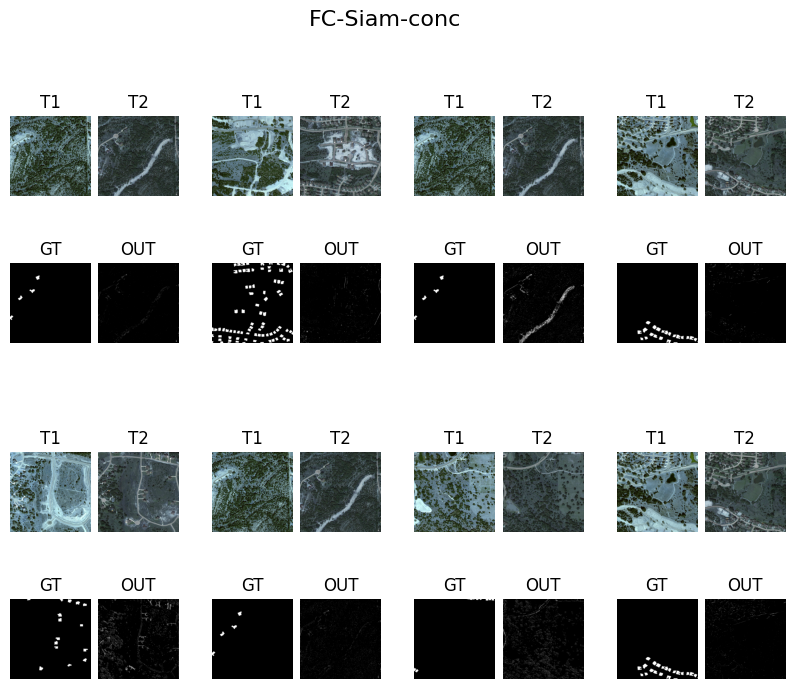

In [ ]:
import data_examination
reload(data_examination)
from data_examination import examine_subset

examine_subset(net, net_name, train_dataset, 10, device)

In [ ]:
test_metrics = evaluate_net_predictions(net, criterion, test_dataset, PATCH_SIZE)

[0.033519501879449944, 0.019546954625693985, 0.07622852852723279, 0.08281686349719054, 0.07978048099692961, 0.07421808254730167, 0.029525623654013577, 0.0720392673055395, 0.07048313243713673, 0.08015992982773311] [0.9992609803369009, 0.22960794575538163, 0.2540099724521075, 0.24772686753431986, 0.25478924999568664, 0.2710390558951915, 0.06485256989055607, 0.2189108517992397, 0.2704955745087101, 0.2754012848014999]




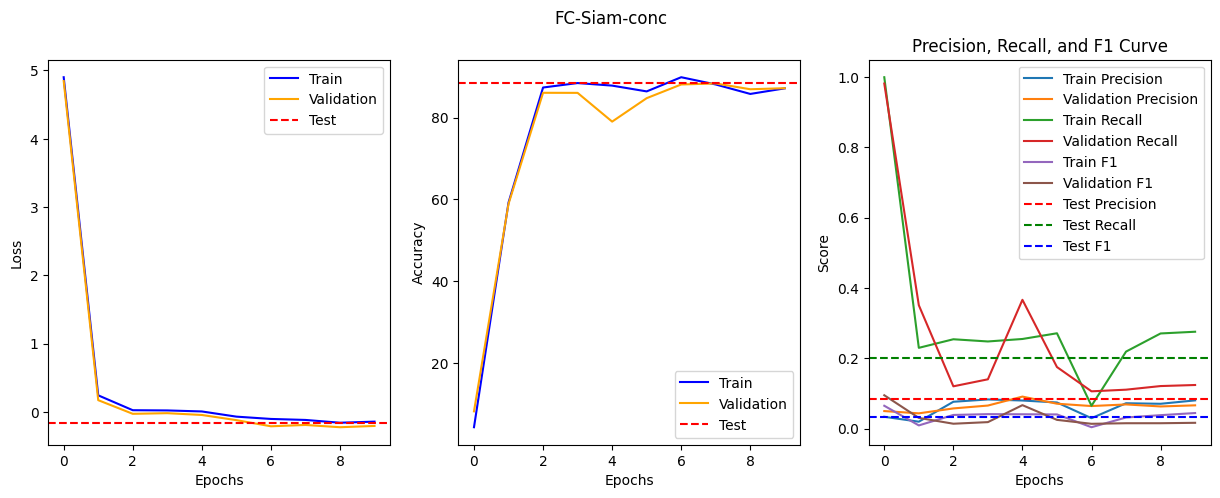

In [ ]:
import tables
import plots
reload(tables)
reload(plots)
from tables import create_tables
from plots import create_figures


create_figures(training_metrics, test_metrics, net_name)
create_tables(training_metrics, test_metrics, net_name)